In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"

In [3]:
from codes.docs.analysis import data_preprocessing,visualisation
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

Notebook 1 description: 
1. Imaging data is imported and preprocessed

Available informations
- Volumetric dataset (dHCP) - 675 individuals / release 2
- Diffusion dataset - 432 individuals
- Microstructure - 318 individuals
- Cortical thickness - 234 individuals
2. Genetic data is added and outliers removed
- Schizophrenia - PRS calculated from GWAS 2020 (Ripke et al., 2020)
- ASD - PRS calculated from GWAS 2019 (Grove et al, 2019)

# 1. Data Preprocessing and Importing

## Importing volumetric, diffusion, microstructural, cortical thickness dataset

### Metadata 

The `dHCP_release3_metadata.tsv` is downloaded from [here](https://biomedia.github.io/dHCP-release-notes/download.html). Total rows = 887

saved in `dataset/participant_info/`

In [5]:
dHCP_metadata = pd.read_csv(f'{dataset_path}/participant_info/dHCP_release3_metadata.tsv',sep='\t')
dHCP_metadata.rename(columns={'participant_id':'ID',
                     'session_id':'Session',
                     'birth_age':'GA',
                     'scan_age':'PMA'},inplace=True)

In [6]:
dHCP_metadata.shape

(887, 39)

### Volumetric dataset

The `volumetric_dataset` contains all the volumetric information for the full cohort. Labels are saved in `Imperial_label` and `AAL_label`.

* AAL is derived by Dafnis.
* DrawEM (preferred method) is part of dHCP pipeline.

Volume are calculated directly from segmentation, where for each label, number of voxel is multiplied by the voxel dimension

`for_each drawem_dseg_FOLDER fslstats -K drawem_dseg.nii.gz drawem_dseg.nii.gz -V`

The following files are available (saved in dataset/volumetric/full_dataset/)

* `allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx` created by Dafnis (likely neonatal release 2). The last subject ID is 1074. Total rows = 750. Contains AAL and DrawEM (750 includes repeated measures)
* `neonatal_release3_DrawEM_Volume_Hai.tsv` created by Hai using segementation files in dhcp-pipeline-data/BIDS_public/rel3_dhcp_anat_pipeline/ 


#### neonatal release 2

In [41]:
#Volumetric dataset neonatal release 2
volumetric_dataset = pd.read_excel(open(
    '../dataset/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                             sheet_name='allSubjectsWithKANA_AALVolumes').drop(
                                 'ID', axis=1)
volumetric_dataset = volumetric_dataset.rename({'Subject': 'ID'}, axis=1)
volumetric_dataset.rename(columns={
    'GA at birth': 'GA',
    'PMA at birth': 'PMA'
},
                    inplace=True)

In [42]:
Imperial_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                               sheet_name='IMPERIAL ROIs LEGEND',
                               header=None).drop([0, 1], axis=1)
AAL_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                          sheet_name='AAL LEGEND',
                          header=None).drop(0, axis=1)

from string import digits

AAL_label = np.asarray(
    [str.split(i, ' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label = np.asarray([
    str.strip(i.translate({ord(c): None
                           for c in digits}))
    for i in (np.asarray(Imperial_label)).reshape(-1)
])

In [43]:
volumetric_dataset = volumetric_dataset.drop(columns=['GA','PMA'])

In [31]:
print('volumetric dataset')
volumetric_dataset.shape

volumetric dataset


(750, 201)

#### neonatal release 3

In [7]:
volumetric_dataset = pd.read_table('../dataset/volumetric/full_dataset/neonatal_release3_DrawEM_Volume_Hai.tsv',delim_whitespace=True,header=None)
volumetric_dataset.columns = ['ID/ses'] + [f'Imperial {i}' for i in range(1,88)]
volumetric_dataset['ID'] = [i.split('/')[0].replace('sub-','') for i in volumetric_dataset['ID/ses']]
volumetric_dataset['Session'] = [i.split('/')[1].replace('ses-','') for i in volumetric_dataset['ID/ses']]
volumetric_dataset['Session'] = volumetric_dataset['Session'].astype('int64')

In [8]:
volumetric_dataset = volumetric_dataset[['ID','Session']+[f'Imperial {i}' for i in range(1,88)]]

In [9]:
volume_9TT_dataset = pd.read_table('../codes/DrawEMVol/9TT.txt',delim_whitespace=True,header=None)
volume_9TT_dataset.columns = ['ID/ses'] + ['CSF','GM','WM','Background','Ventricles','Cerebellum','deepGM','Brainstem','Hipp+Amygdala']
volume_9TT_dataset['ID'] = [i.split('/')[0].replace('sub-','') for i in volume_9TT_dataset['ID/ses']]
volume_9TT_dataset['Session'] = [i.split('/')[1].replace('ses-','') for i in volume_9TT_dataset['ID/ses']]
volume_9TT_dataset['Session'] = volume_9TT_dataset['Session'].astype('int64')
volume_9TT_dataset['TBV']=volume_9TT_dataset[['WM','GM','Cerebellum','deepGM','Brainstem','Hipp+Amygdala']].sum(axis=1)
volume_9TT_dataset['ICV']=volume_9TT_dataset[['CSF','WM','GM','Ventricles','Cerebellum','deepGM','Brainstem','Hipp+Amygdala']].sum(axis=1)
volume_9TT_dataset = volume_9TT_dataset[['ID','Session']+['TBV','ICV','CSF','GM','WM','Background','Ventricles','Cerebellum','deepGM','Brainstem','Hipp+Amygdala']]

In [10]:
volumetric_dataset = pd.merge(volume_9TT_dataset,volumetric_dataset,on=['ID','Session'],how='inner')

In [45]:
volumetric_dataset.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/volumetric_dataset_neonatal_release_3.csv',index=False)

### Diffusion dataset

The diffusion dataset is saved in the matlab file. 
It is saved in the `diffusion_full_dataset`

The labels are saved in the `ROIs_combinations`

In [427]:
ROIs_combinations = data_preprocessing.Diffusion.create_ROIs_combinations(
    f'../../dataset/diff_dataset/Regions_of_Interests.csv')

In [428]:
#Diffusion dataset
diffusion_full_dataset = scipy.io.loadmat(
    f'../../dataset/diff_dataset/2020_04_MASTER_connectomes90_433subj_SCandFC_TermScansVolOK.mat'
)
diffusion_matrices = diffusion_full_dataset[
    'SCmu']  #use the Structural Connectivity (SIFT2-weighted * Mu) [equivalent to raw connectivity, see SIFT2 paper]
diffusion_matrices = [
    diffusion_matrices[:, :, i] for i in range(diffusion_matrices.shape[2])
]  # rearranged them into (433,90,90)
diffusion_matrices = np.asarray(diffusion_matrices)

In [429]:
diffusion_matrices = np.asarray([
    data_preprocessing.Diffusion.lower_triangle(diffusion_matrices[i])
    for i in range(diffusion_matrices.shape[0])
])
diffusion_matrices = pd.DataFrame(diffusion_matrices)

In [430]:
diffusion_matrices.columns = data_preprocessing.Diffusion.lower_triangle(
    ROIs_combinations)

In [431]:
diffusion_subject_id = diffusion_full_dataset['sub'].reshape(-1, 1)
diffusion_subject_id = [
    i[0][0].replace('sub-', '') for i in diffusion_subject_id
]
diffusion_subject_sess = diffusion_full_dataset['ses'].reshape(-1, 1)
diffusion_subject_sess = [
    i[0][0].replace('ses-', '') for i in diffusion_subject_sess
]
diffusion_subject_pma = diffusion_full_dataset['pma'].reshape(-1)
diffusion_subject_ga = diffusion_full_dataset['ga'].reshape(-1)

diffusion_dataset = pd.DataFrame({
    'ID': diffusion_subject_id,
    'Session': diffusion_subject_sess,
    'GA': diffusion_subject_ga,
    'PMA': diffusion_subject_pma
})

# diffusion_dataset['Gender'] = diffusion_full_dataset['sex'].reshape(-1)

#match the ID to the diffusion matrices
diffusion_dataset = pd.concat((diffusion_dataset, diffusion_matrices), axis=1)
diffusion_dataset['Session'] = diffusion_dataset['Session'].astype('int64')
#rearrange by the session, drop the duplicates and keep the last session
# diffusion_dataset = diffusion_dataset.sort_values(by='Session',
#                                                   ascending=False)
# diffusion_dataset = diffusion_dataset.drop_duplicates(subset='ID', keep='last')
# diffusion_dataset = diffusion_dataset.reset_index(drop=True)

In [432]:
print('diffusion dataset')
diffusion_dataset.shape

diffusion dataset


(433, 4009)

In [434]:
diffusion_dataset.to_csv(
    f'{preprocessed_dataset_path}/imaging_data/log_file/diffusion_dataset.csv',
    index=False)

### microstructure dataset

microstructure data contains `FA`, `MD`, etc. 

In [469]:
# Importing the microstructure files
micro_dict_europeans_df = defaultdict(pd.DataFrame)
for file in glob.glob(microstructure_file_path +
                      '/europeans/*-wm-*-stats*.csv'):
    micro = str.split(file, '-')[-3]
    micro_dict_europeans_df[micro] = pd.read_csv(file).dropna(how='any',
                                                              axis=1)
    micro_dict_europeans_df[micro].columns = [
        i + str.upper('_' + micro) if i != 'id' else 'ID'
        for i in micro_dict_europeans_df[micro].columns
    ]  # adding the microstructure name to each of the feature
    micro_dict_europeans_df[micro]['ID'] = [
        i.split('-')[2].split('_')[0]
        for i in micro_dict_europeans_df[micro]['ID']
    ]  # change the ID format

# Adding the microstructure files together into one table.
from functools import reduce

dHCP_microstructure_europeans = reduce(
    lambda left, right: pd.merge(left, right, on='ID', how='outer'), [
        micro_dict_europeans_df['fa'], micro_dict_europeans_df['md'],
        micro_dict_europeans_df['t12'], micro_dict_europeans_df['t2'],
        micro_dict_europeans_df['fiso']
    ])

In [470]:
#### adding asians microstructure files
micro_dict_asians_df = defaultdict(pd.DataFrame)
for file in glob.glob(microstructure_file_path + '/asians/*-wm-*-stats*.csv'):
    micro = str.split(file, '-')[-3]
    micro_dict_asians_df[micro] = pd.read_csv(file).dropna(how='any', axis=1)
    micro_dict_asians_df[micro].columns = [
        i + str.upper('_' + micro) if i != 'id' else 'ID'
        for i in micro_dict_asians_df[micro].columns
    ]  # adding the microstructure name to each of the feature
    micro_dict_asians_df[micro]['ID'] = [
        i.split('-')[2].split('_')[0]
        for i in micro_dict_asians_df[micro]['ID']
    ]  # change the ID format

from functools import reduce

dHCP_microstructure_asians = reduce(
    lambda left, right: pd.merge(left, right, on='ID', how='outer'), [
        micro_dict_asians_df['fa'], micro_dict_asians_df['md'],
        micro_dict_asians_df['t12'], micro_dict_asians_df['t2'],
        micro_dict_asians_df['fiso']
    ])

In [471]:
dHCP_microstructure = pd.concat(
    [dHCP_microstructure_europeans,
     dHCP_microstructure_asians]).reset_index(drop=True)

In [440]:
print('microstructure info')
dHCP_microstructure_info.shape

microstructure info


(318, 276)

In [472]:
dHCP_microstructure.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/microstructure_dataset.csv',index=False)

### Cortical Thickness dataset

`cortical_thickness_df` contains the mean cortical thickness information.

In [447]:
cortical_thickness_df = pd.read_csv('../../dataset/cortical_thickness/cortical_thickness_updated.csv')
cortical_thickness_df.rename(columns={'session':'Session'},inplace=True)
# cortical_thickness_df.drop('session', axis=1, inplace=True)

In [448]:
cortical_thickness_df['Session']

,ID,Session,mean_CC
0,CC00328XX15,104800,1.609608
1,CC00540XX13,164400,1.662574
2,CC00882XX17,13030,1.622470
3,CC00257XX10,84700,1.533126
4,CC00286XX15,91700,1.788949
...,...,...,...
229,CC00217XX11,73700,1.646990
230,CC00255XX08,84400,1.859827
231,CC00675XX16,219100,1.496696
232,CC00247XX17,82801,1.617542


In [459]:
cortical_thickness_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/cortical_thickness_df.csv',index=False)

## Merging all data with PRS scores

- PRS file contains PRS at 11 P-value thresholds, which ranges from 1e-8 to 1.
- The Ancestry files contains the first 10 PCs of the genetic data
- The data can be divided into 3 different ethnic groups: European, South Asian and African
- The outliers are removed to each cohort separately (i.e., European, European + South Asian (called mixed cohort), and European + South Asian + Africans (called full cohort)

In [26]:
# volumetric_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/volumetric_dataset_neonatal_release_3.csv')
# cortical_thickness_df = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/cortical_thickness_df.csv')
# diffusion_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/diffusion_dataset.csv')
# microstructure_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/microstructure_dataset.csv')

In [11]:
full_dataset = volumetric_dataset.merge(dHCP_metadata,on=['ID','Session'],how='right')

In [19]:
# full_dataset = volumetric_dataset.merge(diffusion_dataset,
#                                   on=['ID','Session'],
#                                   suffixes=('_vol', '_diff'),
#                                   how='outer')  #merging the diffusion dataset
# full_dataset = full_dataset.merge(diffusion_dataset,
#                                   on=['ID','Session'],
#                                   suffixes=('_vol', '_diff'),
#                                   how='outer')  #merging the diffusion dataset

# full_dataset = full_dataset.merge(dHCP_metadata,on=['ID','Session'],how='right')

In [23]:
full_dataset.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_full_dataset_release2.csv',index=False)

**run from here**

In [34]:
full_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_full_dataset_release3.csv',index_col=[0])

the following files can be generated
* rel2_batch1
* rel2_batch2
* rel3_batch1
* rel3_batch2

for either asd or genetics

also depends on the type of LD you use.

### batch 1 genetics

In [6]:
european_cohort = genetic_file_preprocess.Cohort(
    cohort_name='euro',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/file3_only_europ_pca.eigenvec',
    imaging_df=full_dataset)

mixed_cohort = genetic_file_preprocess.Cohort(
    cohort_name='mixed',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/euro_asian_361_file3_pca.eigenvec',
    imaging_df=full_dataset)

In [7]:
european_cohort.volumetric_df = european_cohort.extract_neonates_data(columns=['Imperial 1','termness'],criteria={'termness':'term'},remove_duplicates=True) # other options = preterm/term_at_scan
mixed_cohort.volumetric_df = mixed_cohort.extract_neonates_data(columns=['Imperial 1','termness'],criteria={'termness':'term'},remove_duplicates=True) # other options = preterm/term_at_scan

###  batch 2 genetics

In [12]:
european_cohort = genetic_file_preprocess.Cohort(
    cohort_name='euro',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/euro_batch2_genotyped_PCA_result.eigenvec',
    imaging_df=full_dataset)

In [13]:
european_cohort.volumetric_df = european_cohort.extract_neonates_data(columns=['Imperial 1','termness'],criteria={'termness':'term'},remove_duplicates=True) # other options = preterm/term_at_scan


### Removing outliers

Outlier is defined using the Anc PCs. Should I do the this for each dataset or all of them together? Note that the ancestry components for european cohort alone is different from ancestry PCs for european from european and asian cohort mixed

European: 7 term scans were rescanned (excluded duplicates)
Mixed: 7 term scans were rescanned (excluded duplicates) (7 Europeans)
Full: 7 term scans were rescanned (excluded duplicates) (7 Europeans)


Outliers are defined if they have more than 3.5 standard deviation on the AncPC2 and AncPC3

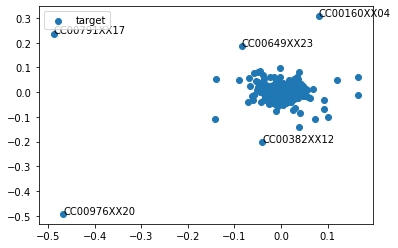

In [14]:
_,_= genetic_file_preprocess.Cohort.remove_outliers(
    european_cohort.volumetric_df,
    to_examine=['euro_Anc_PC3', 'euro_Anc_PC4'],
    to_annotate='ID')

In [15]:
from codes.docs.analysis import data_exploration

In [16]:
test = data_exploration.MassUnivariate.remove_outliers(
    european_cohort.volumetric_df,
    col=['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3','euro_Anc_PC4'],
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.5).ID.tolist()

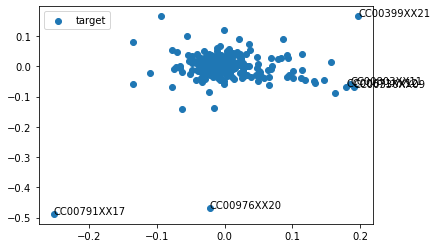

In [21]:
european_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
    european_cohort.volumetric_df,
    to_examine=['euro_Anc_PC2', 'euro_Anc_PC3'],
    to_annotate='ID')

# mixed_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
#     mixed_cohort.volumetric_df,
#     to_examine=['mixed_Anc_PC4', 'mixed_Anc_PC5'],
#     to_annotate='ID')

# full_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
#     full_cohort.volumetric_df,
#     to_examine=['full_Anc_PC7', 'full_Anc_PC8'],hue='cohort',
#     to_annotate='ID')

In [15]:
_

Index(['CC00791XX17', 'CC00160XX04', 'CC00976XX20', 'CC00382XX12',
       'CC00399XX21', 'CC00511XX08', 'CC00649XX23'],
      dtype='object', name='ID')

!!! Important I have less mixed values in ASD than SCZ

In [22]:
_

Index(['CC00803XX11', 'CC00791XX17', 'CC00976XX20', 'CC00399XX21',
       'CC00330XX09', 'CC00671XX12'],
      dtype='object', name='ID')

In [16]:
scz_prs_batch1_euro = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../dataset/PRS/scz/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_updated.gwas.all.score',column_prefix='SCZ_PRS_') # SCZ all LDs batch 1

scz_prs_batch2_euro = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../dataset/PRS/scz/SCZ3core_nodups_euro_batch2_genotyped.gwas.all_score',column_prefix='SCZ_PRS_') # SCZ all LDs batch 1

asd_prs_batch1_euro = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score', column_prefix = 'ASD_PRS_') # ASD euro LDs batch 1

asd_prs_batch2_euro = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../dataset/PRS/asd/ASD_nodups_euro_batch2_genotyped.gwas.all_score',column_prefix='ASD_PRS_') # SCZ all LDs batch 1


scz_prs_batch1_mixed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../dataset/PRS/scz/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_ASIAN_361.gwas.all.score',column_prefix='SCZ_PRS_') # SCZ all LDs batch 1

asd_prs_batch1_mixed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEAN_ASIAN.gwas.all.score', column_prefix = 'ASD_PRS_') # ASD euro LDs batch 1


In [17]:
european_cohort.volumetric_df = european_cohort.volumetric_df.merge(scz_prs_batch1_euro,on='ID',how='inner')
european_cohort.volumetric_df = european_cohort.volumetric_df.merge(asd_prs_batch1_euro,on='ID',how='inner')

mixed_cohort.volumetric_df = mixed_cohort.volumetric_df.merge(scz_prs_batch1_mixed,on='ID',how='inner')
mixed_cohort.volumetric_df = mixed_cohort.volumetric_df.merge(asd_prs_batch1_mixed,on='ID',how='outer')

In [17]:
european_cohort.volumetric_df = european_cohort.volumetric_df.merge(scz_prs_batch2_euro,on='ID',how='inner')
european_cohort.volumetric_df = european_cohort.volumetric_df.merge(asd_prs_batch2_euro,on='ID',how='inner')


### saving preprocessed data without outliers

In [21]:
european_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch1.csv',index=False)

mixed_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/rel3/volumetric/mixed_volumetric_df_rel3_batch1.csv',index=False)

In [33]:
mixed_cohort.volumetric_df.shape

(256, 359)

In [19]:
european_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv',index=False)

In [60]:
european_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/rel2/volumetric/test_european_volumetric_df_rel2_batch2.csv',index=False)
